# Analysis of usa-housing-dataset-with-states.csv

The file is an interesting mix of pricing, location, physical characteristics, and community evaluation data. This analysis was done early on, with surprising results (not necessarily good), and it prompted some revision and reconsiderations.

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
import xgboost as xgb

A brief look at the data reveals a mostly-complete, albeit small dataset of 300 rows and 11 columns. Some interesting finds include the following:
* an average house price of $~522k
* an average bedroom count of ~3
* an average bathroom count of ~2.5
* an average footage of ~3000
* an average built year of 1962
* an average garage of of ~1.5 cars
* an average of lot size of ~1 acre
* an average of 49/100 crime rating
* an average of 5/10 crime rating

On average, these homes are designated as middle or upper middle class, with their spacious accommodations and high price point.

In [97]:
df = pd.read_csv('./postprocessed_data/usa-housing-dataset-with-states.csv')
print(df.head())
print(df.info())
print(df.describe())

    Price  Bedrooms  Bathrooms  SquareFeet  YearBuilt  GarageSpaces  LotSize  \
0  221958         1        1.9        4827       1979             2     1.45   
1  771155         2        2.0        1035       1987             2     1.75   
2  231932         1        3.0        2769       1982             1     1.46   
3  465838         3        3.3        2708       1907             3     1.62   
4  359178         4        3.4        1175       1994             2     0.74   

   ZipCode  CrimeRate  SchoolRating State  
0    82240      48.60             5    WY  
1    74315      92.03             9    OK  
2    79249      52.08             3    TX  
3    80587      61.65             1    CO  
4    20756      15.66             4    MD  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         300 non-null    int64  
 1   Bedrooms      30

We'll want to prepare the data for modeling. At the same time, might as well check for any strong relationships between features using a correlation matrix. Preprocessing includes the following:
* dropping values
* encoding non-numericals
* standardizing numericals

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


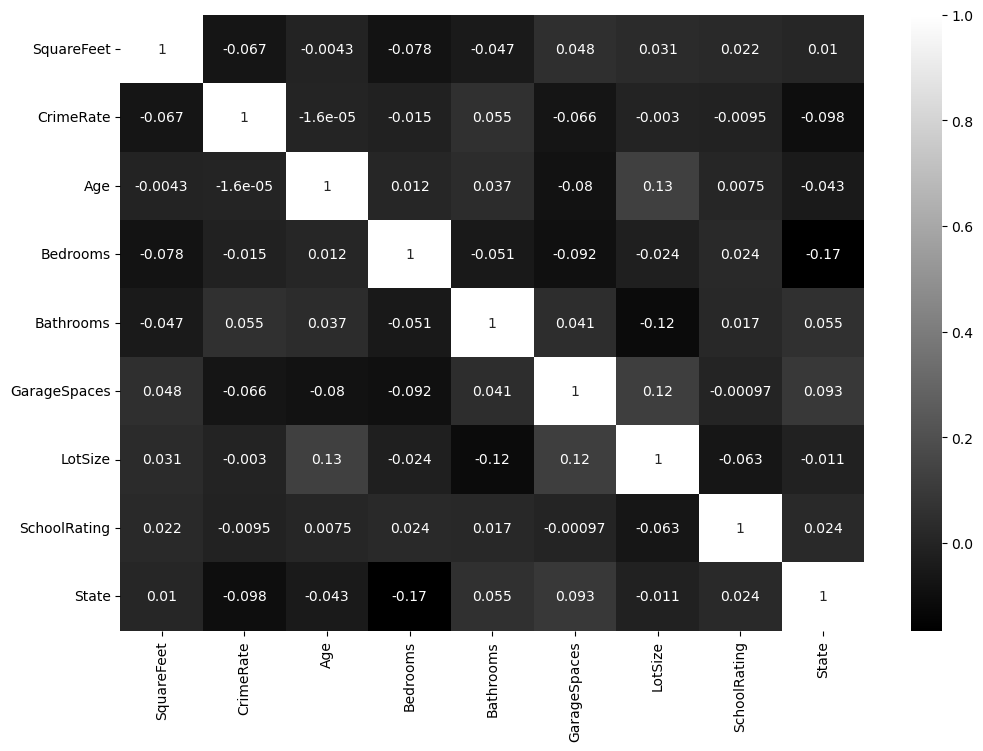

In [98]:
# clean
df['Age'] = 2025 - df['YearBuilt']
df.drop(['YearBuilt', 'ZipCode'], axis=1, inplace=True)
df.dropna(inplace=True)
column_order = ['SquareFeet', 'CrimeRate', 'Age', "Price", "Bedrooms", "Bathrooms", "GarageSpaces", "LotSize", "SchoolRating", "State"]
df = df[column_order]

# encode the state
encoder = LabelEncoder()
df['State'] = encoder.fit_transform(df['State'].values.reshape(-1, 1))

# split the data
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# combined_training_data = pd.concat([X_train, y_train], axis=1)

# standardize
scaler = StandardScaler()
columns_to_scale = ['SquareFeet', 'CrimeRate', 'Age']
columns_to_ignore = ["Bedrooms", "Bathrooms", "GarageSpaces", "LotSize", "SchoolRating", "State"]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, columns_to_scale)
    ],
    remainder='passthrough'
)
# Fit, transform, and convert the dataset
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# show correlation matrix
columns_transformed = columns_to_scale + columns_to_ignore
df_correlation_matrix = pd.DataFrame(X_train_scaled, columns=columns_transformed)
correlation_matrix = df_correlation_matrix.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='grey')
plt.show()

Let's test the model and see how it does. The results are as follows:

Linear Regression Results:
  * Mean Squared Error: 75679816566.33786
  * R-squared Score: -0.039849538950929464

Random Forest Results:
  * Mean Squared Error: 73394453236.17204
  * R-squared Score: -0.008448379262266714

XGBoost Results:
  * Mean Squared Error: 72991107572.15358
  * R-squared Score: -0.0029063626216765392



Pretty bad results. It was improved compared to the following previous results, but still did not significantly improve.

Linear Regression Results:
* Mean Squared Error: 70597692136.68445
* R-squared Score: -0.033919157433573544

Random Forest Results:
* Mean Squared Error: 71108152392.66861
* R-squared Score: -0.04139496325380687

XGBoost
* RMSE: 80887792335.49518
* r2 -0.18462000055551275

In [99]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred_result = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, pred_result)
    r2 = r2_score(y_test, pred_result)
    print(f"{name} Results:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  R-squared Score: {r2}")

Linear Regression Results:
  Mean Squared Error: 75679816566.33786
  R-squared Score: -0.039849538950929464
Random Forest Results:
  Mean Squared Error: 73394453236.17204
  R-squared Score: -0.008448379262266714
XGBoost Results:
  Mean Squared Error: 72991107572.15358
  R-squared Score: -0.0029063626216765392
